In [1]:
import os
from segment_anything.build_sam import sam_model_registry
from scripts.experiments.mask_aug.inference import class_inference, load_model
from scripts.sam_train import SamTrain
from segment_anything.modeling.sam import Sam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.datasets.constant import IMAGE_TYPE
from scripts.datasets.preprocess_raw import FLARE22_Preprocess
from scripts.utils import torch_try_load
from scripts.experiments.mask_aug.inference import get_all_organ_range

%matplotlib inline

VAL_ROOT = "../dataset/FLARE22-version1/ReleaseValGT-20cases"
sym = "02"
VOLUME_CACHE = os.path.join(VAL_ROOT, f"FLARETs_00{sym}_0000.cache.pt")
IMAGE_PATH = os.path.join(VAL_ROOT, f"images/FLARETs_00{sym}_0000.nii.gz")
MASK_PATH = os.path.join(VAL_ROOT, f"labels/FLARETs_00{sym}.nii.gz")
# MODEL_PATH = "../runs/transfer/imp-230603-150046/model-20.pt"
# MODEL_PATH = "../runs/exps-230701-165310/model-20.pt"
MODEL_PATH = "../runs/transfer/imp-aug-230610-211354/model-40.pt"
MODEL_PATH = "../runs/exps-230707-112408/model-80.pt"
model: Sam = sam_model_registry["vit_b"](
        checkpoint="../sam_vit_b_01ec64.pth", custom=MODEL_PATH
    )
sam_train = SamTrain(sam_model=model)
preprocessor = FLARE22_Preprocess()

In [3]:
from scripts.experiments.beam_search.beam_search_engine import BeamSearchInferenceEngine
import torch
volumes, masks = preprocessor.run_with_config(
    image_file=IMAGE_PATH,
    gt_file=MASK_PATH,
    config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
)
cache_volume = torch_try_load(VOLUME_CACHE, 'cpu')
engine = BeamSearchInferenceEngine(
    volumes=volumes, 
    caches=cache_volume, 
    masks=masks,
    sam_train=sam_train,
    stability_config=None,
    start_radius=10,
    gaussian_config={'sigma': 20.0},
    strategy_name='local-mean-centroid',
    # default
    grid_config=None,
    allow_evolution=True,
)
start_idx=engine.starts[1]
end_idx=engine.ends[1]
print(f"Start inference from: ({start_idx}, {end_idx})")
(
    forward_data,
    backward_data,
    init_mask,
    proposal_start_idx,
    forward_score, 
    backward_score
) = engine.beam_search_inference(
    start_idx=start_idx,
    end_idx=end_idx,
    target_idx=1,
    beam_width=10,
)
print(proposal_start_idx)
# data = np.stack([*backward_data[::-1], *forward_data])
data, score = engine.compose_result(backward_data, forward_data, forward_score, backward_score, start_idx, end_idx)

Start inference from: (102, 161)
Exceed cyclic count...
Exceed cyclic count...
[160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140]
Exceed cyclic count...
Exceed cyclic count...
Exceed cyclic count...
[103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
140


In [14]:
end_idx - start_idx + 1

60

Text(0.5, 1.0, 'Image')

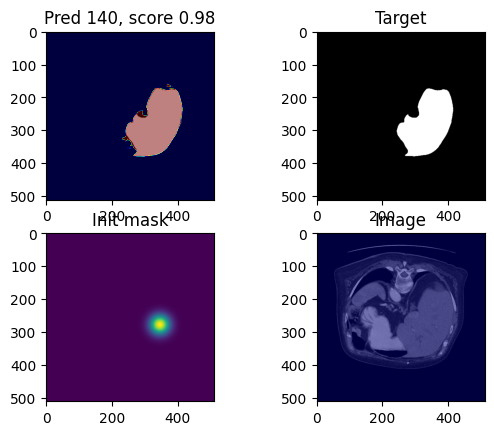

In [4]:
# idx = start_idx + 39
idx = proposal_start_idx
target_mask = masks[idx].copy() == 1
img = volumes[idx]
f, axes = plt.subplots(2, 2)
# plt.imshow(Image1, cmap='gray')
target_mask = np.stack([target_mask, target_mask, target_mask]).transpose([1, 2, 0]).astype(np.uint16) * 255
axes[0, 0].imshow(target_mask, interpolation=None)
axes[0, 0].imshow(data[idx], cmap='jet', interpolation=None, alpha=0.5)

axes[0, 1].imshow(target_mask)
axes[1, 0].imshow(init_mask[0])

axes[1, 1].imshow(
    np.stack([img]*3).transpose(1, 2, 0).astype(np.uint16)
)
axes[1, 1].imshow(data[idx - start_idx], cmap='jet', interpolation=None, alpha=0.5)
actual_score = score[idx - start_idx]
axes[0, 0].set_title(f'Pred {idx}, score {actual_score:.2f}')
axes[0, 1].set_title('Target')
axes[1, 0].set_title('Init mask')
axes[1, 1].set_title('Image')

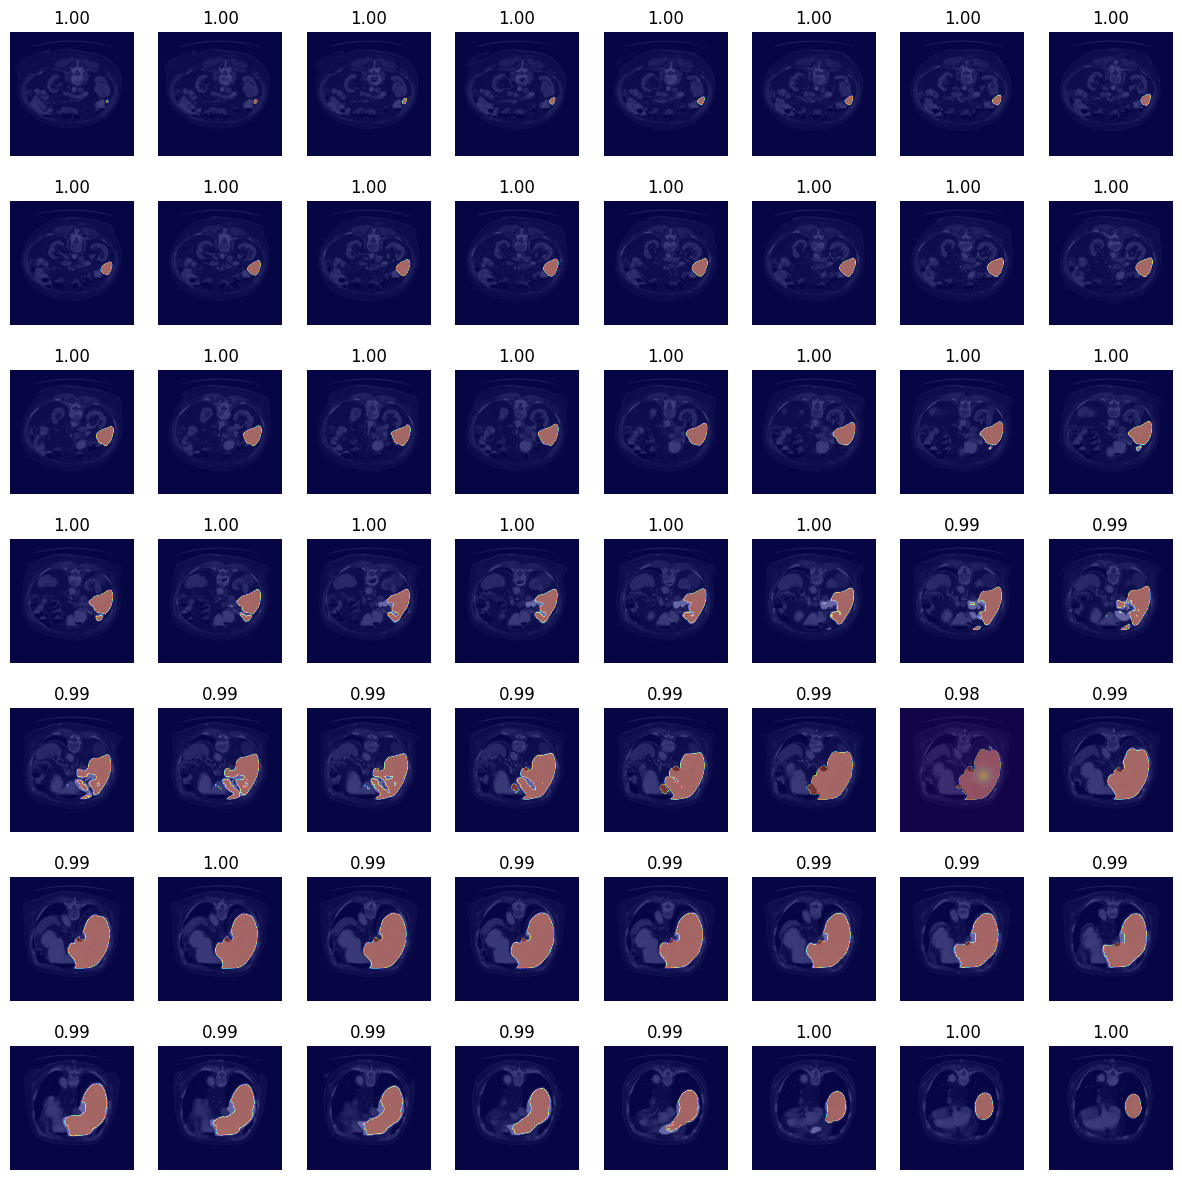

In [5]:
def grid_imshow(data: np.ndarray, start_idx: int, end_idx:int, proposal_start_idx: int, init_mask, score):
    l = end_idx - start_idx + 1
    n_row = int(np.sqrt(l))
    n_col = int(np.ceil(l // n_row))
    f, axes = plt.subplots(n_row, n_col, figsize=(15, 15), squeeze=False)
    for row in range(n_row):
        for col in range(n_col):
            idx = row * n_col + col
            if idx >= l: break
            actual_score = score[idx]
            pred_mask = data[idx + start_idx]
            target_mask = masks[idx + start_idx].copy() == 1
            target_img = volumes[idx + start_idx].copy()
            # img = volumes[idx]
            target_mask = np.stack([target_mask] * 3).transpose([1, 2, 0]).astype(np.uint16) * 255
            target_img = np.stack([target_img] * 3).transpose([1, 2, 0])
            
            axes[row, col].imshow(target_img, interpolation=None, alpha=0.9)
            axes[row, col].imshow(target_mask, interpolation=None, alpha=0.5)
            axes[row, col].imshow(pred_mask, cmap='jet', interpolation=None, alpha=0.5)
            axes[row, col].axis('off')
            if idx + start_idx == proposal_start_idx:
                axes[row, col].imshow(init_mask, interpolation=None, alpha=0.2)

            axes[row, col].set_title(f"{actual_score:.2f}")
            
    plt.show()

grid_imshow(data, start_idx, end_idx, proposal_start_idx, init_mask[0], score)

In [ ]:


# volumes, masks = preprocessor.run_with_config(
#     image_file=IMAGE_PATH,
#     gt_file=MASK_PATH,
#     config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
# )
# cache_volume = torch_try_load(VOLUME_CACHE, 'cpu')
# engine = BeamSearchInferenceEngine(
#     volumes=volumes, 
#     caches=cache_volume, 
#     masks=masks,
#     sam_train=sam_train,
#     stability_config=None,
#     start_radius=100,
#     gaussian_config={'sigma': 3.0},
#     strategy_name='local-mean-centroid',
#     # default
#     grid_config=None,
#     allow_evolution=True,
# )



In [ ]:
# import itertools
# from scripts.experiments.beam_search.beam_search_engine import make_centroid, make_gauss_point_mask

# engine.start_radius = 30
# engine.gaussian_config = {
#     'sigma': 20.0,
# }
# width = 200
# size = 3

# proposal = make_centroid(engine.masks, engine.LOCAL_MEAN_CENTROID)
# z, y, x = proposal[1].tolist()

# xs = np.ceil(np.linspace(
#     start=x-width/2, stop=x+width/2, num=size,
# )).astype(np.int32)
# ys = np.ceil(np.linspace(
#     start=y-width/2, stop=y+width/2, num=size
# )).astype(np.int32)

# # print(x, y, xs, ys)
# init_mask = np.zeros((512, 512))
# dist = 0.0
# for x_point, y_point in list(itertools.product(xs, ys)):
#     dist = max(dist, np.sqrt(np.square(x_point - x) + np.square(y_point - y)))

# max_dist = dist
# for x_point, y_point in list(itertools.product(xs, ys)):
#     dist = np.sqrt(np.square(x_point - x) + np.square(y_point - y))
#     ratio = (1 - dist / max_dist)
#     radius = int(int(engine.start_radius) * ratio)
#     radius = max(radius, 3)
#     # print(x_point, y_point, radius, ratio)
#     _tmp = make_gauss_point_mask(
#         x=x_point,
#         y=y_point,
#         radius=radius,
#         gaussian_config=engine.gaussian_config,
#     )
#     init_mask = init_mask + _tmp.numpy()
#     pass
# f, axes = plt.subplots(2, 2)
# axes[0, 0].imshow(init_mask)
# axes[0, 1].imshow(np.stack([volumes[z]] * 3).transpose(1, 2, 0))
# axes[1, 0].imshow(masks[z])

In [ ]:
# engine.start_radius = 100
# init_mask, proposal_start_idx = engine.seeding_strategies(
#     target_idx=1,
#     start_idx=engine.starts[1],
#     end_idx=engine.ends[1],
# )

# chosen_idx, mask_logits = engine.core_inference(
#     idx=proposal_start_idx,
#     previous_mask=init_mask[-1]
# )
# f, axes = plt.subplots(2, 2)
# axes[0, 0].imshow(engine.masks[proposal_start_idx])
# axes[0, 1].imshow(torch.sigmoid(mask_logits[0, chosen_idx]).numpy() > 0.5)
# axes[1, 0].imshow(torch.sigmoid(mask_logits[0, chosen_idx]).numpy())
# axes[1, 1].imshow(init_mask[-1])


In [ ]:
from glob import glob

gt_files = sorted(list(glob(f"{VAL_ROOT}/labels/*nii.gz")))
image_files = sorted(list(glob(f"{VAL_ROOT}/images/*nii.gz")))

In [ ]:
len(gt_files)

In [ ]:
# Only care about the liver
local_mean_centroid = np.zeros((14, 3))
local_mean_centroid[1] = np.array([0.38626369, 0.54490201, 0.67218827])

def make_centroid(masks, local_mean_centroid: np.ndarray):
    # NOTE: Remember to reverse the masks
    starts, ends = get_all_organ_range(masks)
    starts = np.nan_to_num(starts.astype(np.float32), nan=0.0)
    ends = np.nan_to_num(ends.astype(np.float32), nan=0.0)
    dur = ends - starts
    dur: np.ndarray = np.pad(
        np.reshape(dur, [-1, 1]), 
        pad_width=[(0, 0), (0, 2)], 
        constant_values=512
    )
    # Take the centroid in z-axis of local organ, and then add back the starts
    proposal = dur * local_mean_centroid + np.pad(
        np.reshape(starts, [-1, 1]), 
        pad_width=[(0, 0), (0, 2)], 
        constant_values=0.0
    )
    
    return np.ceil(proposal).astype(np.uint16)


In [ ]:
file_idx = 7
volumes, masks = preprocessor.run_with_config(
    image_file=image_files[file_idx],
    gt_file=gt_files[file_idx],
    config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
)
volumes, masks = volumes[::-1], masks[::-1]
proposal = make_centroid(masks, local_mean_centroid)
z, y, x = proposal[1].tolist()

plt.imshow(masks[z] == 1.0)
plt.plot(x, y, markersize=10, marker="o")

In [ ]:
is_ins = []
for file_idx in range(0, 20):
    volumes, masks = preprocessor.run_with_config(
        image_file=image_files[file_idx],
        gt_file=gt_files[file_idx],
        config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
    )
    volumes, masks = volumes[::-1], masks[::-1]
    z, y, x = volumes.shape
    x_mean_per, y_mean_per, z_mean_per = (0.6721882690535713, 0.5449020087665863, 0.352355387374095)
    x = int(x * x_mean_per)
    y = int(y * y_mean_per)
    z = int(z * z_mean_per)
    is_in = masks[z, y, x]
    is_ins.append(is_in)
    # plt.imshow(masks[z] == 1.0)
    # plt.plot(x, y, markersize=10, marker="o")

In [ ]:
is_ins

In [ ]:

# for file_idx in range(0, 20):
file_idx = 7
volumes, masks = preprocessor.run_with_config(
    image_file=image_files[file_idx],
    gt_file=gt_files[file_idx],
    config_name=IMAGE_TYPE.ABDOMEN_SOFT_TISSUES_ABDOMEN_LIVER,
)
volumes, masks = volumes[::-1], masks[::-1]
z, y, x = volumes.shape
x_mean_per, y_mean_per, z_mean_per = (0.6721882690535713, 0.5449020087665863, 0.352355387374095)
x = int(x * x_mean_per)
y = int(y * y_mean_per)
z = int(z * z_mean_per)
plt.imshow(masks[z])
plt.plot(x, y, markersize=10, marker="o")

In [ ]:
def confidence_score(logits, threshold):
    # Idea: confidence is high when the prob of 
    # foreground high and prob of background is low
    foreground_score = np.mean(logits[logits >= threshold])
    background_score = 1.0 - np.mean(logits[logits < threshold])
    return np.mean([foreground_score, background_score])

sigmoid_mask = tracing_tool[0][-1][-1]

In [ ]:
max(tracing_tool[0], key=lambda x: x[1])

In [ ]:
max(tracing_tool[0], key=lambda x: x[1])[-1]

In [ ]:
sigmoid_masks = torch.sigmoid(sigmoid_mask)
mask_threshold = 0.5
threshold_offset = 0.1
intersections = (
            (sigmoid_masks > (mask_threshold + threshold_offset))
            .sum(-1, dtype=torch.int16)
            .sum(-1, dtype=torch.int32)
        )

unions = (
            (sigmoid_masks > (mask_threshold - threshold_offset))
            .sum(-1, dtype=torch.int16)
            .sum(-1, dtype=torch.int32)
        )
print(intersections, unions)

In [ ]:
confidence_score(logits=torch.sigmoid(sigmoid_mask).numpy(), threshold=0.5)

(512, 512)


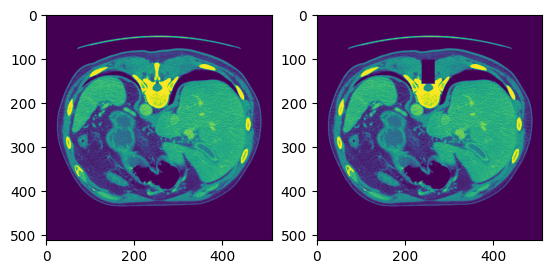

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scripts.service.inference import InferenceService, parse_bbox_data

with open("./mockReqMedical (1).txt", 'r') as out:
    data = json.load(out)

service = InferenceService(base_model_path="../sam_vit_b_01ec64.pth", model_path=None)
img = service.decode_image(data['image'])
x, y, w, h = parse_bbox_data(data)
f, axes = plt.subplots(1, 2)
print(img.shape)
# tmp = np.zeros((512, 512))
tmp = img.copy()
tmp[y:y+h, x:x+w] = 0.0
axes[0].imshow(img)
axes[1].imshow(tmp)
